# Convolutional Autoencoder with clustering
64 Pixel version

@ Martin Kraus

In [1]:
import numpy as np #numpy, matrizenzeugs
import tensorflow as tf #deep learning
import matplotlib.pyplot as plt #plots
from sklearn.preprocessing import LabelBinarizer #labelbinarizer um Text labels zu encoden
import os #erkennt OS und baut pfade richtig
%matplotlib inline 
# plots
%config InlineBackend.figure_format = 'retina' #ploteinstellung

input_dir = 'C:/Users/Martin/Untitled Folder 1/'#pfad wo bilder NP gespeichert sind

directories = os.listdir(input_dir) #setze diesen pfad betriebssystem spezifisch

In [2]:
#load preloaded data, daten wurden mit Data_load.ipynb erstellt
images = np.load('X_64_train.npy') #Saving train image arrays
labels = np.load('Y_64_train.npy')#Saving train labels)

In [3]:
np.shape(images)
#plt.imshow(images[0])

(3511, 64, 64, 3)

In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

isEncoded = False
enc = OneHotEncoder()

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    global isEncoded
    
    if not isEncoded:
        enc.fit(x)  
        
        
    return enc.transform(x).toarray()

In [5]:
#labels = one_hot_encode(labels)

In [6]:
#randomize data
order_vec = np.array(range(len(images)))
#print(order_vec)
np.random.shuffle(order_vec)
#print(order_vec)

images = images[order_vec]
labels = labels[order_vec]

In [7]:
#baue batches
def get_img_batch(batch_nr, batch_size,max_size):
    if (batch_nr+1)*batch_size > max_size:
        indices = range(batch_nr*batch_size, max_size)
    else:
        indices = range(batch_nr*batch_size,((batch_nr+1)*batch_size))
    batches_images = images[indices]
    
    return batches_images

In [8]:

#get_im_batches(batch_nr,batch_size, total_nr )

In [9]:
#normalise images
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
 # TODO: Implement Function
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)  




In [10]:

#normalize images
images = normalize(images)

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

![Convolutional Autoencoder](assets/convolutional_autoencoder.png)

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughlt 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **deconvolutional** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but it reverse. A stride in the input layer results in a larger stride in the deconvolutional layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a deconvolutional layer. Deconvolution is often called "transpose convolution" which is what you'll find the TensorFlow API, with [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, deconvolutional layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor).

In [11]:
inputs_ = tf.placeholder(tf.float32, (None, 64, 64, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 64, 64, 3), name='targets')
factor = 3
### Encoder
conv1 = tf.layers.conv2d(inputs_, 16*factor, (3,3), padding='same', activation=tf.nn.relu)
# Now 64x64x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 32x32x16
conv2 = tf.layers.conv2d(maxpool1, 8*factor, (3,3), padding='same', activation=tf.nn.relu)
# Now 16x16x24
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 8x8x24
conv3 = tf.layers.conv2d(maxpool2, 8*factor, (3,3), padding='same', activation=tf.nn.relu)
# Now 8x8x72
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same', name='encoded')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (16,16))
# Now 8x8x8
conv4 = tf.layers.conv2d(upsample1, 8*factor, (3,3), padding='same', activation=tf.nn.relu)
# Now 8x8x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (32,32))
# Now 16x16x8
conv5 = tf.layers.conv2d(upsample2, 8*factor, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (64,64))
# Now 32x32x8
conv6 = tf.layers.conv2d(upsample3, 16*factor, (3,3), padding='same', activation=tf.nn.relu)
# Now 32x32x16

logits = tf.layers.conv2d(conv6, 3, (3,3), padding='same', activation=None)
#Now 32*32*3

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
#loss = tf.losses.mean_squared_error(labels=targets_, predictions=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 64x64x3
arrays.

In [12]:
sess = tf.Session()

In [13]:
len(images)

3511

In [16]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(len(images)//batch_size):
        imgs = get_img_batch(ii, batch_size, len(images))
        #print(np.shape(imgs))
        #imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6871
Epoch: 1/20... Training loss: 0.6652
Epoch: 1/20... Training loss: 0.6270
Epoch: 1/20... Training loss: 0.5706
Epoch: 1/20... Training loss: 0.5157
Epoch: 1/20... Training loss: 0.5270
Epoch: 1/20... Training loss: 0.5196
Epoch: 1/20... Training loss: 0.5222
Epoch: 1/20... Training loss: 0.4907
Epoch: 1/20... Training loss: 0.4843
Epoch: 1/20... Training loss: 0.5012
Epoch: 1/20... Training loss: 0.4948
Epoch: 1/20... Training loss: 0.4993
Epoch: 1/20... Training loss: 0.4814
Epoch: 1/20... Training loss: 0.4781
Epoch: 1/20... Training loss: 0.4533
Epoch: 1/20... Training loss: 0.4729
Epoch: 2/20... Training loss: 0.4626
Epoch: 2/20... Training loss: 0.4652
Epoch: 2/20... Training loss: 0.4621
Epoch: 2/20... Training loss: 0.4554
Epoch: 2/20... Training loss: 0.4443
Epoch: 2/20... Training loss: 0.4407
Epoch: 2/20... Training loss: 0.4234
Epoch: 2/20... Training loss: 0.4376
Epoch: 2/20... Training loss: 0.4213
Epoch: 2/20... Training loss: 0.4099
E

Epoch: 13/20... Training loss: 0.2780
Epoch: 14/20... Training loss: 0.2782
Epoch: 14/20... Training loss: 0.2859
Epoch: 14/20... Training loss: 0.2791
Epoch: 14/20... Training loss: 0.2813
Epoch: 14/20... Training loss: 0.2759
Epoch: 14/20... Training loss: 0.2832
Epoch: 14/20... Training loss: 0.2656
Epoch: 14/20... Training loss: 0.2780
Epoch: 14/20... Training loss: 0.2783
Epoch: 14/20... Training loss: 0.2677
Epoch: 14/20... Training loss: 0.2767
Epoch: 14/20... Training loss: 0.2725
Epoch: 14/20... Training loss: 0.2806
Epoch: 14/20... Training loss: 0.2744
Epoch: 14/20... Training loss: 0.2781
Epoch: 14/20... Training loss: 0.2700
Epoch: 14/20... Training loss: 0.2792
Epoch: 15/20... Training loss: 0.2781
Epoch: 15/20... Training loss: 0.2857
Epoch: 15/20... Training loss: 0.2784
Epoch: 15/20... Training loss: 0.2796
Epoch: 15/20... Training loss: 0.2742
Epoch: 15/20... Training loss: 0.2819
Epoch: 15/20... Training loss: 0.2646
Epoch: 15/20... Training loss: 0.2785
Epoch: 15/20

# Speichern vom Model

In [74]:
#save model
save_model_path = 'sessions/'
saver = tf.train.Saver()
save_path = saver.save(sess, save_model_path )

In [ ]:
#lade von trainierter Session
save_model_path = 'sessions/'
loader = tf.train.import_meta_graph(save_model_path + '.meta')
loader.restore(sess, save_model_path)

# Plote Ergebnisse von Autoencoding

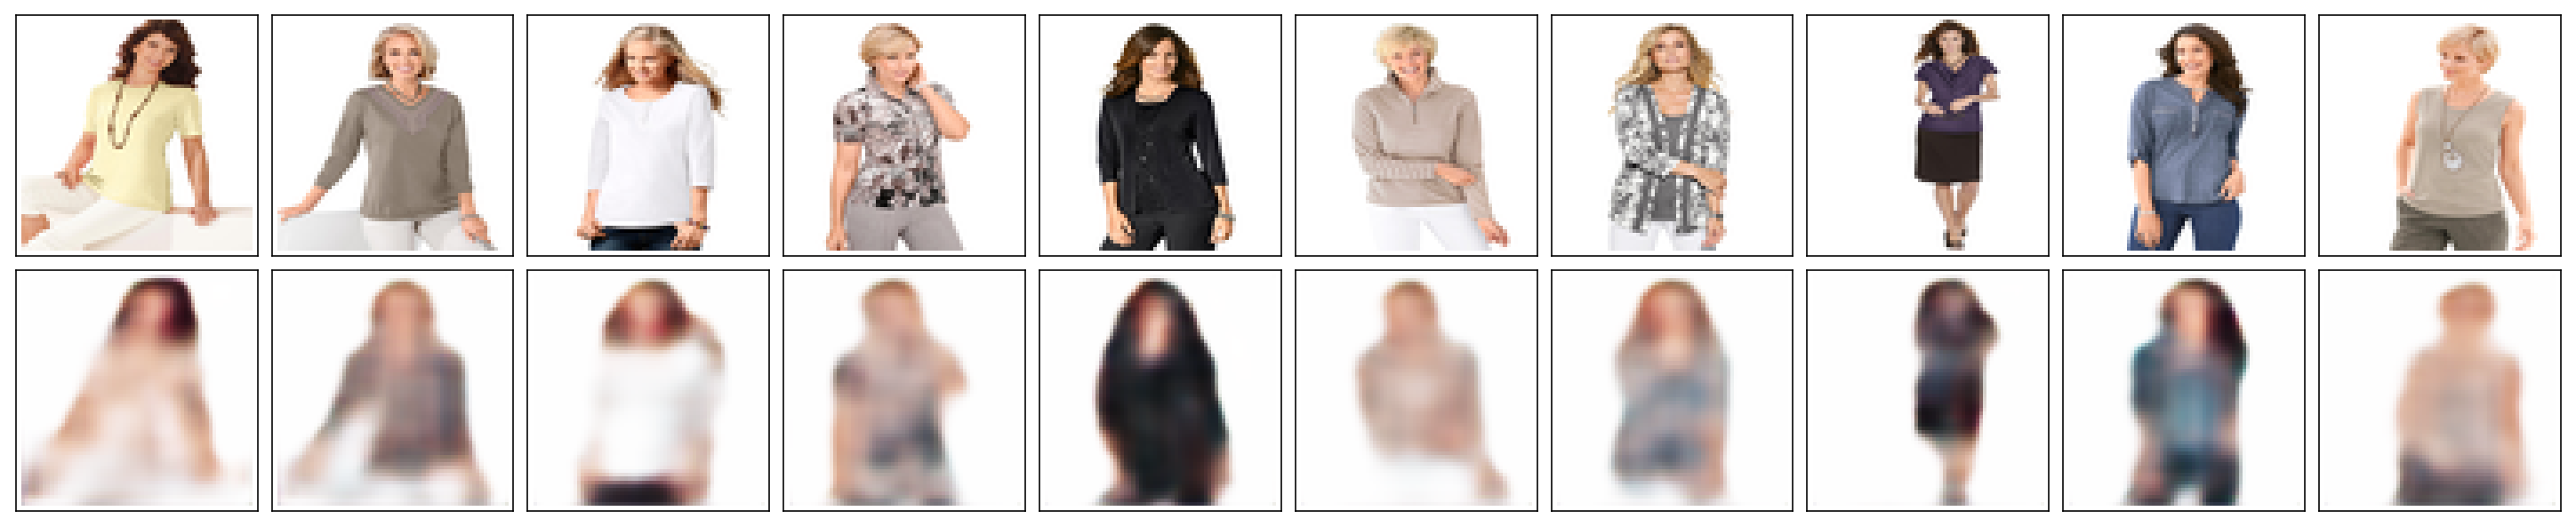

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs})

for images_for_plot, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images_for_plot, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

# Clustering with TSNE
Lade und erstelle vordefinierte Funktionen

In [36]:
#functions for TSNE Plot
from sklearn.manifold import TSNE
import numpy as np
from skimage.transform import resize

from matplotlib import pyplot as plt

def gray_to_color(img):
    if len(img.shape) == 2:
        img = np.dstack((img, img, img))
    return img

def min_resize(img, size):
    """
    Resize an image so that it is size along the minimum spatial dimension.
    """
    w, h = map(float, img.shape[:2])
    if min([w, h]) != size:
        if w <= h:
            img = resize(img, (int(round((h/w)*size)), int(size)))
        else:
            img = resize(img, (int(size), int(round((w/h)*size))))
    return img

def image_scatter(features, images, img_res, res=4000, cval=1.):
    """
    Embeds images via tsne into a scatter plot.
    Parameters
    ---------
    features: numpy array
        Features to visualize
    images: list or numpy array
        Corresponding images to features. Expects float images from (0,1).
    img_res: float or int
        Resolution to embed images at
    res: float or int
        Size of embedding image in pixels
    cval: float or numpy array
        Background color value
    Returns
    ------
    canvas: numpy array
        Image of visualization
    """
    features = np.copy(features).astype('float64')
    images = [gray_to_color(image) for image in images]
    images = [min_resize(image, img_res) for image in images]
    max_width = max([image.shape[0] for image in images])
    max_height = max([image.shape[1] for image in images])
    # Verwendung TSNE anstatt PCA
    tsne = TSNE(n_components=2)
    fitted_tsne = tsne.fit_transform(features)
    #df_fitted_tsne = pd.DataFrame(fitted_tsne,
    #                             columns=['x', 'y'],
    #                             index=range(0, len(artikels_tsne)))
    #f2d = bh_sne(features)
    #print(np.shape(images))
    xx = fitted_tsne[:, 0]
    yy = fitted_tsne[:, 1]
    x_min, x_max = xx.min(), xx.max()
    y_min, y_max = yy.min(), yy.max()
    # Fix the ratios
    sx = (x_max-x_min)
    sy = (y_max-y_min)
    if sx > sy:
        res_x = int(sx/float(sy)*res)
        res_y = res
    else:
        res_x = res
        res_y = int(sy/float(sx)*res)

    canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
    x_coords = np.linspace(x_min, x_max, res_x)
    y_coords = np.linspace(y_min, y_max, res_y)
    for x, y, image in zip(xx, yy, images):
        w, h = image.shape[:2]
        x_idx = np.argmin((x - x_coords)**2)
        y_idx = np.argmin((y - y_coords)**2)
        canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image
    return canvas

# Clusterplot 
Jetzt werden die Bilder durch den encoder geschickt und die komprimierten INformationen für das TSNE Verfahren genutzt

(3000, 64, 64, 3)


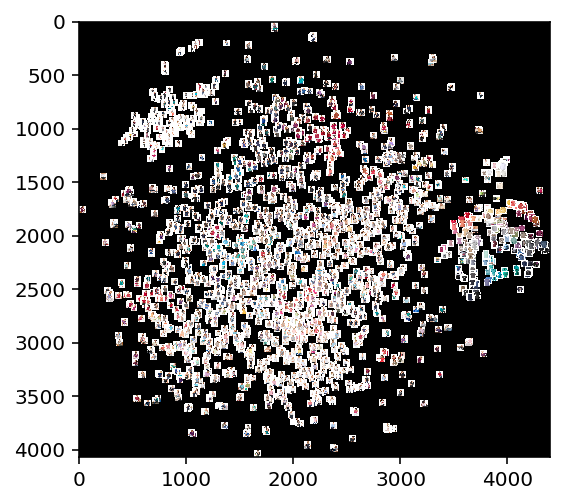

In [75]:
#Wähle Input Bilder aus
nr_images = 3000
in_imgs = images[:nr_images]
#encoden lassen
encoded_arr = sess.run(encoded, feed_dict={inputs_: in_imgs})
#np.shape(encoded_ret)
shape_encoder = np.shape(encoded_arr)

#müssen reshaped werden
reshaped_encoded = np.reshape(encoded_arr, (nr_images,np.prod(shape_encoder[1:])))

#plot daten erstellen
image_scatter_ret = image_scatter(reshaped_encoded, in_imgs, img_res=64, res=4000, cval=0.)
#plotten
#%matplotlib inline
plt.imshow(image_scatter_ret)
#abspeicher des Plots
plt.savefig('clustering.png', dpi = 1000)
plt.savefig("clustering.pdf", dpi = 1000)

24.5053261806
